In [2]:
%matplotlib inline
import pylab as pb
import numpy as np
# pylab.ion()
import GPy

In [3]:
#This functions generate data corresponding to two outputs
f_output1 = lambda x: 4. * np.cos(x/5.) - .4*x - 35. + np.random.rand(x.size)[:,None] * 2.
f_output2 = lambda x: 6. * np.cos(x/5.) + .2*x + 35. + np.random.rand(x.size)[:,None] * 8.


#{X,Y} training set for each output
X1 = np.random.rand(100)[:,None]; X1=X1*75
X2 = np.random.rand(100)[:,None]; X2=X2*70 + 30
Y1 = f_output1(X1)
Y2 = f_output2(X2)
#{X,Y} test set for each output
Xt1 = np.random.rand(100)[:,None]*100
Xt2 = np.random.rand(100)[:,None]*100
Yt1 = f_output1(Xt1)
Yt2 = f_output2(Xt2)



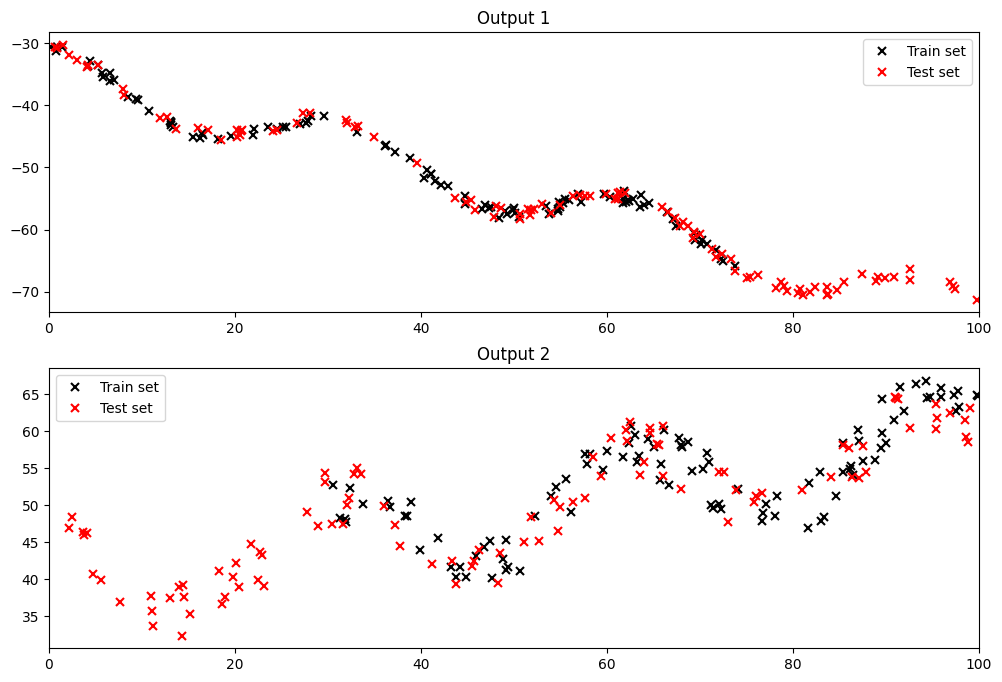

In [4]:
xlim = (0,100); ylim = (0,50)
fig = pb.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
ax1.set_xlim(xlim)
ax1.set_title('Output 1')
ax1.plot(X1[:,:1],Y1,'kx',mew=1.5,label='Train set')
ax1.plot(Xt1[:,:1],Yt1,'rx',mew=1.5,label='Test set')
ax1.legend()
ax2 = fig.add_subplot(212)
ax2.set_xlim(xlim)
ax2.set_title('Output 2')
ax2.plot(X2[:,:1],Y2,'kx',mew=1.5,label='Train set')
ax2.plot(Xt2[:,:1],Yt2,'rx',mew=1.5,label='Test set')
ax2.legend()

In [5]:
def plot_2outputs(m,xlim,ylim):
    fig = pb.figure(figsize=(12,8))
    #Output 1
    ax1 = fig.add_subplot(211)
    ax1.set_xlim(xlim)
    ax1.set_title('Output 1')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,0)],which_data_rows=slice(0,100),ax=ax1)
    ax1.plot(Xt1[:,:1],Yt1,'rx',mew=1.5)
    #Output 2
    ax2 = fig.add_subplot(212)
    ax2.set_xlim(xlim)
    ax2.set_title('Output 2')
    m.plot(plot_limits=xlim,fixed_inputs=[(1,1)],which_data_rows=slice(100,200),ax=ax2)
    ax2.plot(Xt2[:,:1],Yt2,'rx',mew=1.5)


In [6]:
import GPy
K=GPy.kern.RBF(1)
B = GPy.kern.Coregionalize(input_dim=1,output_dim=2) 
multkernel = K.prod(B,name='B.K')
print(multkernel)

  B_K.             |   value  |  constraints  |  priors
  rbf.variance     |     1.0  |      +ve      |        
  rbf.lengthscale  |     1.0  |      +ve      |        
  coregion.W       |  (2, 1)  |               |        
  coregion.kappa   |    (2,)  |      +ve      |        


In [7]:
#Components of B
print('W matrix\n',B.W)
print('\nkappa vector\n',B.kappa)
print('\nB matrix\n',B.B)

W matrix
   index  |   coregion.W  |  constraints  |  priors
  [0 0]  |   0.27989352  |               |        
  [1 0]  |  -0.45043395  |               |        

kappa vector
   index  |  coregion.kappa  |  constraints  |  priors
  [0]    |      0.50000000  |      +ve      |        
  [1]    |      0.50000000  |      +ve      |        

B matrix
 [[ 0.57834038 -0.12607354]
 [-0.12607354  0.70289074]]


In [8]:
icm = GPy.util.multioutput.ICM(input_dim=1,num_outputs=2,kernel=GPy.kern.RBF(1))
print(icm)

  ICM.             |   value  |  constraints  |  priors
  rbf.variance     |     1.0  |      +ve      |        
  rbf.lengthscale  |     1.0  |      +ve      |        
  B.W              |  (2, 1)  |               |        
  B.kappa          |    (2,)  |      +ve      |        



Name : gp
Objective : 366.6419090834361
Number of Parameters : 8
Number of Optimization Parameters : 7
Updates : True
Parameters:
  gp.                                    |                value  |  constraints  |  priors
  ICM.Mat32.variance                     |                  1.0  |   +ve fixed   |        
  ICM.Mat32.lengthscale                  |   218.42573421711504  |      +ve      |        
  ICM.B.W                                |               (2, 1)  |               |        
  ICM.B.kappa                            |                 (2,)  |      +ve      |        
  mixed_noise.Gaussian_noise_0.variance  |  0.28983566307035924  |      +ve      |        
  mixed_noise.Gaussian_noise_1.variance  |   5.0404322059502755  |      +ve      |        


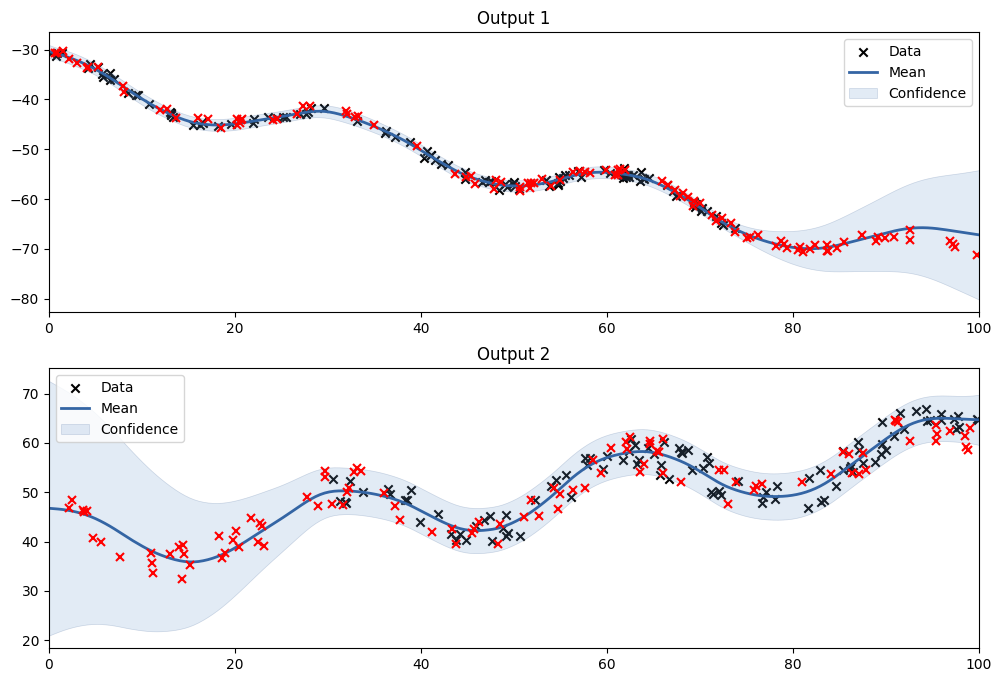

In [9]:
K = GPy.kern.Matern32(1)
icm = GPy.util.multioutput.ICM(input_dim=1,num_outputs=2,kernel=K)

m = GPy.models.GPCoregionalizedRegression([X1,X2],[Y1,Y2],kernel=icm)
m['.*Mat32.var'].constrain_fixed(1.) #For this kernel, B.kappa encodes the variance now.
m.optimize()
print(m)
plot_2outputs(m,xlim=(0,100),ylim=(-20,60))

Text(0.5, 1.0, 'Output 2')

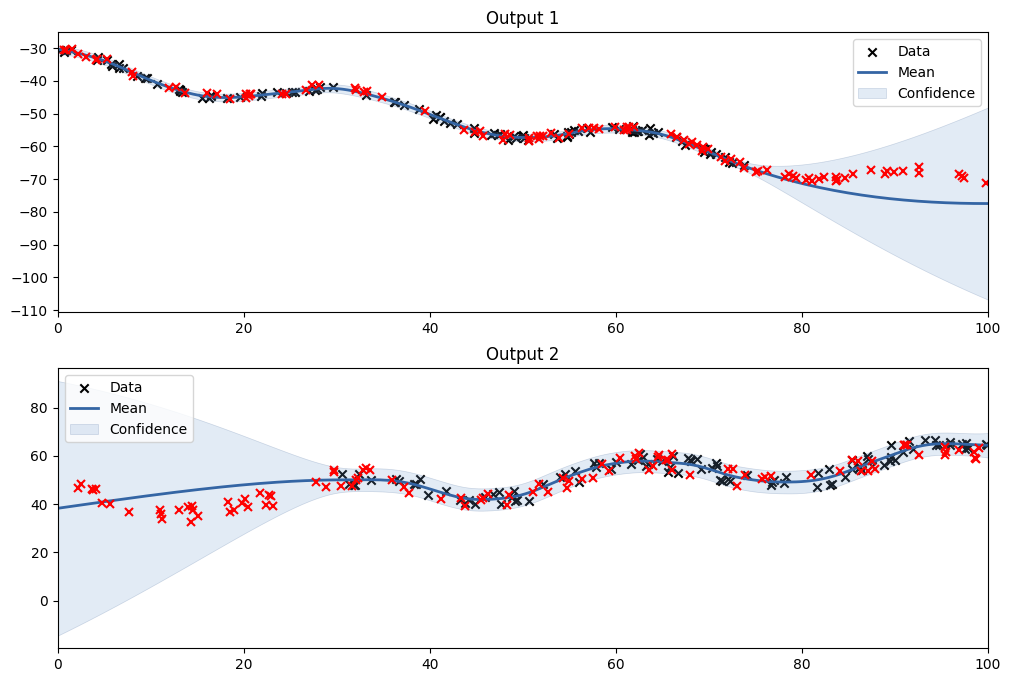

In [10]:
K = GPy.kern.Matern32(1)

m1 = GPy.models.GPRegression(X1,Y1,kernel=K.copy())
m1.optimize()
m2 = GPy.models.GPRegression(X2,Y2,kernel=K.copy())
m2.optimize()
fig = pb.figure(figsize=(12,8))
#Output 1
ax1 = fig.add_subplot(211)
m1.plot(plot_limits=xlim,ax=ax1)
ax1.plot(Xt1[:,:1],Yt1,'rx',mew=1.5)
ax1.set_title('Output 1')
#Output 2
ax2 = fig.add_subplot(212)
m2.plot(plot_limits=xlim,ax=ax2)
ax2.plot(Xt2[:,:1],Yt2,'rx',mew=1.5)
ax2.set_title('Output 2')

In [14]:
newX = np.arange(80,100)[:,None]
newX = np.hstack([newX,np.ones_like(newX)])
print(newX)

[[80  1]
 [81  1]
 [82  1]
 [83  1]
 [84  1]
 [85  1]
 [86  1]
 [87  1]
 [88  1]
 [89  1]
 [90  1]
 [91  1]
 [92  1]
 [93  1]
 [94  1]
 [95  1]
 [96  1]
 [97  1]
 [98  1]
 [99  1]]


In [15]:
noise_dict = {'output_index':newX[:,1:].astype(int)}

In [16]:
out = m.predict(newX,Y_metadata=noise_dict)

In [17]:
out[0]

array([[49.40668595],
       [49.81326338],
       [50.44252579],
       [51.31516481],
       [52.44108886],
       [53.76917094],
       [55.19127426],
       [56.62793892],
       [58.03610056],
       [59.4303043 ],
       [60.80382467],
       [62.09382388],
       [63.20240643],
       [64.05535885],
       [64.6230617 ],
       [64.9196165 ],
       [65.00514841],
       [64.95724447],
       [64.86228071],
       [64.77261849]])

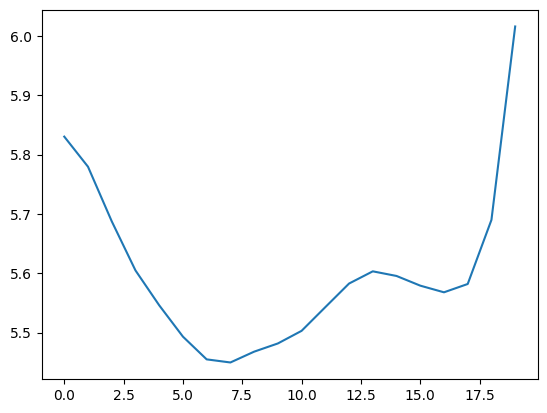

In [18]:
pb.plot(out[1])